In [1]:
%matplotlib inline
import numpy as np 
import scipy.special as sp
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
import numpy.random as rnd 
#import math 

# Monte Carlo Integration

Suppose we want to estimate the following integral $\int_{0}^{1} e^x \; dx$. The minimum value of the function is $1$ at $x=0$ and the max is $e$ at $x=1$.

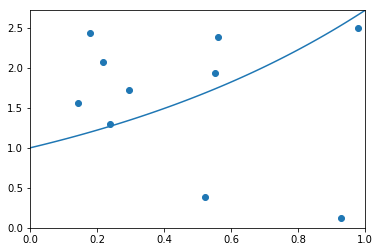

In [10]:
# Generate uniform rnd points in the square [0,1]x[0,e]
pts = np.random.uniform(0,1,(10, 2))
pts[:, 1] *= np.e # is tha max value

x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(x));

plt.scatter(pts[:, 0], pts[:, 1])
plt.xlim([0,1])
plt.ylim([0, np.e]);

In [6]:
# Check analytic solution

from sympy import symbols, integrate, exp

x = symbols('x')
expr = integrate(exp(x), (x,0,1))
expr.evalf()

1.71828182845905

In [44]:
# Monte Carlo approximation

from timeit import default_timer as timer


def MC_integrate(pts):
    pts_tot = len(pts)
    pts_below = 0
    for i in range(pts_tot):
        # if the point is below the function count+=1
        if pts[i,1] < np.exp(pts[i,0]):
            pts_below += 1
    area = np.e * 1 
    sol = (float(pts_below)/pts_tot)* area
    return sol

# The following is a more efficient way
def MC_integrate_eff(pts):
    pts_tot = len(pts)
    pts_below = np.sum(pts[:, 1] < np.exp(pts[:, 0]))
    area = np.e * 1 
    sol = (float(pts_below)/pts_tot)* area
    return sol

print '\t n \t MC \t\t EXC \t\t perc err \t time \t\t time_eff'
for tot_pts in 10**np.array([1,2,3,4,5,6,7]):
    # Generate uniform rnd points in the square [0,1]x[0,e]
    my_pts = np.random.uniform(0,1,(tot_pts, 2))
    my_pts[:, 1] *= np.e # is tha max value
    
    start = timer()
    sol = MC_integrate(my_pts)
    end = timer()
    time = end - start
    
    start = timer()
    sol_eff = MC_integrate_eff(my_pts)
    end = timer()
    time_eff = end - start
    
    err = abs(sol - expr.evalf())/float(expr.evalf())
    print '%10d \t %.6f \t %.6f \t %.6f \t %.6f \t %.6f' % (tot_pts, sol_eff, expr.evalf(), err, time, time_eff)



	 n 	 MC 		 EXC 		 perc err 	 time 		 time_eff
        10 	 1.630969 	 1.718282 	 0.050814 	 0.000079 	 0.000064
       100 	 1.549421 	 1.718282 	 0.098273 	 0.000397 	 0.000088
      1000 	 1.701644 	 1.718282 	 0.009683 	 0.003237 	 0.000214
     10000 	 1.744593 	 1.718282 	 0.015313 	 0.032448 	 0.000335
    100000 	 1.710506 	 1.718282 	 0.004525 	 0.218280 	 0.001469
   1000000 	 1.719305 	 1.718282 	 0.000596 	 2.188035 	 0.013396
  10000000 	 1.718355 	 1.718282 	 0.000042 	 21.231776 	 0.151685


# Metropolis Algorithm

Suppose that we want to generate random variables according to an arbitrary probability density $P(x)$. The Metropolis algorithm produces a random walk of points $\{x_i\}$ whose asymptotic probability approaches  $P(x)$ after a large number of steps. The random walk is defined by a transition probability $w(x_i \rightarrow x_j)$ for one value $x_i$ to another $x_j$ in order that the distribution of points $x_0$, $x_1$,  $x_2$, ... converges to $P(x)$.

In can be shown that it is sufficient (but not necessary) to satisfy the detailed balance condition 

$$
p(x_i)w(x_i \rightarrow x_j) = p(x_j)w(x_j \rightarrow x_i).
$$

This relation does not specify  $w(x_i \rightarrow x_j)$ uniquely. A simple choice is 

$$
w(x_i \rightarrow x_j)=\min{\left[ 1,\frac{P(x_j)}{P(x_i)} \right] }.
$$

This choice can be described by the following steps. Suppose that the random walker is a position $x_n$. To generate $x_{n+1}$ we
choose a trial position  $x_t=x_n+\delta _n$ , where the $\delta _n$ is a random number in the interval  $[-\delta ,\delta]$.
Calculate  $w=P(x_t)/P(x_n)$.

* If $w \geq 1$ we accept the change and let $x_{n+1}=x_t$.
* If $w \leq 1$, generate a random number $r$.
* If $r \leq w$, accept the change and let $x_{n+1}=x_t$.
* If the trial change is not accepted, the let $x_{n+1}=x_n$.


In [107]:
from math import pi, sqrt, factorial

def normal_pdf(x):
    # Standard Normal PDF (Prob. Density Function)
    return np.exp(-0.5*x**2)/sqrt(2*pi)

def poisson_pdf(x):
    # Standard Normal PDF (Prob. Density Function)
    return x*np.exp(-x)

#sdnorm(0)

In [106]:
# Check that the PDF integrates to 1 over [-infty, +infty]

def normal_pdf_ck(x):
    # Standard Normal PDF (Prob. Density Function)
    return exp(-0.5*x**2)/sqrt(2*pi)

def poisson_pdf_ck(x):
    # Standard Normal PDF (Prob. Density Function)
    return x*exp(-x)

from sympy import symbols, integrate, exp

t = symbols('t')
expr = integrate(normal_pdf_ck(t), (t,-10,10))
print expr.evalf()

expr = integrate(poisson_pdf_ck(t), (t,0,10))
print expr.evalf()

1.00000000000000
0.999500600772613


In [108]:
#random_innov = np.random.uniform(-delta,delta,n) #random inovation, uniform proposal distribution

def metropolis(n, delta, pdf):
    x = 0.
    count = 0
    random_walk = []
    for i in xrange(1, n):
        random_innov = np.random.uniform(-delta, delta)
        xt = x + random_innov # candidate
        accept_prob = min([1., pdf(xt) / pdf(x)]) #acceptance probability
        rnd_unif = np.random.uniform(0,1)
        if rnd_unif < accept_prob:
            x = xt
            random_walk.append(x)
            count += 1
    rate_accept = float(count)/n
    return random_walk, rate_accept

#metropolis(10, 1)

/Users/Yak52/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars


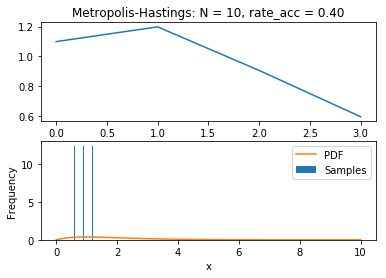

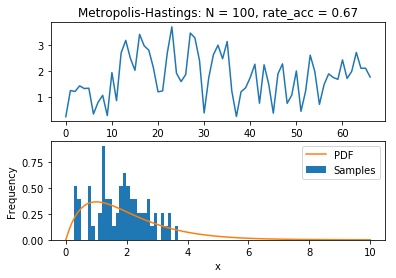

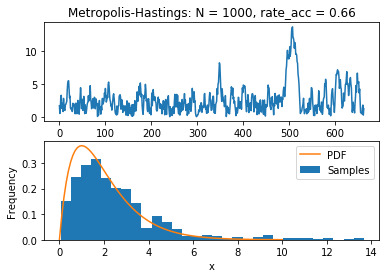

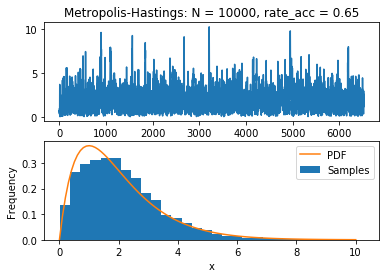

In [112]:
#xx = np.linspace(-3,3,100)
xx = np.linspace(0,10,100)
my_delta = 2
#my_pdf = normal_pdf
my_pdf = poisson_pdf

for n in 10**np.array([1,2,3,4]):
    random_walk, rate_accept = metropolis(n, my_delta, my_pdf)
    plt.subplot(211)
    plt.title('Metropolis-Hastings: N = %d, rate_acc = %.2f' % (n, rate_accept))
    plt.plot(random_walk)
    plt.subplot(212)

    plt.hist(random_walk, bins=30, normed=1)
    plt.plot(xx, my_pdf(xx),'-')
    plt.ylabel('Frequency')
    plt.xlabel('x')
    plt.legend(('PDF','Samples'))
    plt.show()

# Compute Integral with Metropolis Algorithm

L'algoritmo di Metropolis-Hastings serve a generare dei numeri $x_1, x_2, \dots, x_n$ che presentano una distribuzione $p(x)$ fissata a priori.

Calculate using metropolis  

$$\frac{1}{\sqrt{2 \pi}}\int f(x) \; e^{-\frac{1}{2}x^2} dx$$

Just to be sure of the result check that for $f(x) = x^2$ the result is 1.



In [11]:
def my_x0(dim_sample):
    # Generates an uniform sample of dim_sample
    ret = np.random.uniform(-1, 1)
    return ret

gen_unif_sample(3)

array([ 0.89695379,  0.52357843,  0.55315741])

$$
-\frac{1}{2}x^2 + \frac{1}{2}(x + \delta)^2 = -\frac{1}{2}x^2 + \frac{1}{2}x^2 + \frac{1}{2}\delta^2
+x\delta = \frac{1}{2}\delta^2
+x\delta
$$

In [8]:
def my_func(x):
    return x**2

def my_x0():
    # Generates a random variable from uniform distribution
    ret = np.random.uniform(-1, 1)
    return ret

def my_delta():
    # Generates a random variable from normal distribution
    ret = np.random.normal(0,1)
    return ret

def markov_iteration(x0, delta):
    # Generate the Markov Chain (The function is a generator. Note 'yield')
    x = x0()
    while True:
        dd = delta()
        xt = x + delta() # candidate 
        r = min(1, np.exp(-0.5*xt*xt) / np.exp(-0.5*x*x))
        accepted = (np.random.uniform() < r)
        if accepted:
            x = xt
        yield x
            

#mm = markov_iteration()

#print mm
#for i in range(5):
#    print next(mm)    # ogni volta che chiami next parte dal while loop saltando ciò che sta prima


def metropolis_integrator(x0, delta, func, niter):
    mm = markov_iteration(x0, delta)
    f = 0
    for i in range(niter/100):
        next(mm)
    for i in range(niter):
        f = f + func(next(mm))
    fn = f/niter
    return fn

print metropolis_integrator(my_x0, my_delta, my_func, 1000)
print metropolis_integrator(my_x0, my_delta, my_func, 10000)
#print metropolis_integrator(my_x0, my_delta, my_func, 100000)
    
        
    
    


0.932593732301
1.01791189182


In [54]:
def tau_estimation(func, niter, x0 = my_x0, delta = my_delta):
    mm = markov_iteration(x0, delta)
    f_values = np.zeros(niter)
    for i in range(niter):
        f_values[i] = func(next(mm))
    mu = np.mean(f_values)
    var = np.var(f_values)
    tau_val = []
    gran = 30
    for k in range(gran, niter/gran, gran):
        f_group_by_k = np.zeros(niter/k)
        for i in range(niter/k):
            f_group_by_k[i] = sum(f_values[k*i:k*(i+1)])
        f_group_by_k = (1./k)*f_group_by_k
        var_k = sum(((f_group_by_k - mu)**2))/(niter/k)
        tau_val.append([k,k*var_k/var])
    return tau_val
            

#print tau_estimation(my_func, 10000)         
num_iters = 100000
tau_vals = np.array(tau_estimation(my_func, num_iters))


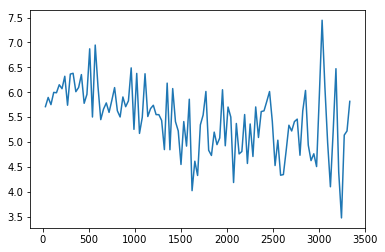

In [55]:
plt.plot(tau_vals[:,0], tau_vals[:,1])
plt.show()

In [61]:
sigmas = np.linspace(0.5,20,20)
mean_tau_list = []
for sig in sigmas:
    loc_delta = lambda : np.random.normal(0,sig)
    vals = tau_estimation(my_func, num_iters, my_x0, loc_delta)
    vals = np.array(vals)
    mu = np.mean(vals[:,1])
    mean_tau_list.append(mu)
    
print mean_tau_list
    

    

[13.469481648661899, 5.0414022360408861, 4.8601674581258871, 6.3795562169614115, 5.8034893640573584, 7.3819816228331883, 8.9373368272888687, 12.28848947487916, 12.166135323645653, 13.855428342558792, 16.536850700471536, 17.363142911352035, 18.195715770786933, 16.551494964943672, 25.077657362117485, 25.680054321006399, 26.034473090166259, 24.931115916524231, 26.573766257941713, 25.509454523286745]


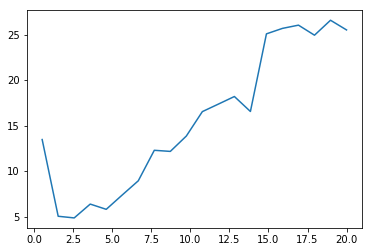

In [62]:
plt.plot(sigmas, mean_tau_list)
plt.show()